# Exploring a rose garden with SPARQL

*Philippe Rocca-Serra (philippe.rocca-serra[at]oerc.ox.ac.uk), University of Oxford e-Research Centre

In [1]:
import rdflib
from rdflib import Graph, RDF
from IPython.core.display import display, HTML
import os
import json
import csv
import uuid

from SPARQLWrapper import SPARQLWrapper, SPARQLWrapper2, JSON, JSONLD, CSV, TSV, N3, RDF, RDFXML, TURTLE
import pandas as pds
import itertools

import numpy as np
from plotnine import *


In [2]:
def queryResultToHTMLTable(queryResult):
    
   HTMLResult = '<table><tr style="color:white;background-color:#43BFC7;font-weight:bold">'
   # print variable names and build header:
   for varName in queryResult.vars:
       HTMLResult = HTMLResult + '<td>' + varName + '</td>'
   HTMLResult = HTMLResult + '</tr>'

   # print values from each row and build table of results
   for row in queryResult:
      HTMLResult = HTMLResult + '<tr>'   
      for column in row:
        #print("COLUMN:", column)
        if column is not "":
             HTMLResult = HTMLResult + '<td>' +  str(column) + '</td>'
        else:
             HTMLResult = HTMLResult + '<td>' + "N/A"+ '</td>'
      HTMLResult = HTMLResult + '</tr>'
   HTMLResult = HTMLResult + '</table>'
   display(HTML(HTMLResult))

In [3]:
def get_sparql_variables(results, sparql_wrapper="SPARQLWrapper2"):
#     return results.vars if ("sparqlwrapper2" == sparql_wrapper.lower()) else results['head']['vars']
    return results.vars if ("sparqlwrapper2" == sparql_wrapper.lower()) else results.vars


def get_sparql_bindings(results, sparql_wrapper="SPARQLWrapper2"):
    return results.bindings if ("sparqlwrapper2" == sparql_wrapper.lower()) else results['results']['bindings']


def get_sparql_binding_variable_value(binding, variable, sparql_wrapper="SPARQLWrapper2"):
    return binding[variable] if ("sparqlwrapper2" == sparql_wrapper.lower()) else binding[variable]['value']

def make_sparql_dict_list(bindings, variables, sparql_wrapper="SPARQLWrapper2"):
    def binding_value(binding, var): # helper function for returning values
        return get_sparql_binding_variable_value(binding, var, sparql_wrapper) if (var in binding) else None

    dict_list = []  # list to contain dictionaries
    for binding in itertools.chain(bindings):
        values = [binding_value(binding, var) for var in itertools.chain(variables)]
        dict_list.append(dict(zip(variables, values)))

    return dict_list


def make_sparql_df(results, sparql_wrapper="SPARQLWrapper2"):
    variables = get_sparql_variables(results, sparql_wrapper)
    # print(variables)

    cleaned_variables=[str(var.replace('\\n','')) for var in variables] 

    #print(cleaned_variables)
    bindings = get_sparql_bindings(results, sparql_wrapper)
    # print(bindings)
    
    # create a list of dictionaries to use as data for dataframe
    data_list = make_sparql_dict_list(bindings, cleaned_variables, sparql_wrapper)
    
    # print(data_list)

    df = pds.DataFrame(data_list) # create dataframe from data list
    df["sample_mean"] = df["sample_mean"].astype("float")

   # print(df["sample_mean"])
    return df[cleaned_variables] # return dataframe with columns reordered

*credits to Bob du Charme for the following function [http://www.snee.com/bobdc.blog/2016/07/sparql-in-a-jupyter-aka-ipytho.html]

In [4]:
g = Graph()

Let's read the RDF graph generated using the rose-dtpkg2rdf.py python script and saved to disk as a turtle file

In [5]:
#g.parse("./../data/processed/rose-data-as-rdf/rose-aroma-ng-06-2018-subset.ttl", format="n3")
g.parse("./../data/processed/rose-data-as-rdf/rose-aroma-ng-06-2018-full.ttl", format="n3")
# g.parse("./../data/processed/denovo/rdf/rose-aroma-ng-06-2018-full.ttl", format="n3")

<Graph identifier=Nd1ad6b7e59304524b5c3700e7bc1d8a2 (<class 'rdflib.graph.Graph'>)>

Now let's ask for the independent variables and their levels using the following SPARQL query

In [6]:
get_idv_and_levels = g.query("""
PREFIX stato: <http://purl.obolibrary.org/obo/STATO_>
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
PREFIX ncbitax: <http://purl.obolibrary.org/obo/NCBITaxon_>
prefix has_part: <http://purl.obolibrary.org/obo/BFO_0000051>
            SELECT DISTINCT
             ?Predictor
             ?PredictorLevel
             WHERE { 
                ?var a stato:0000087 ;
                    rdfs:label ?Predictor ;
                    has_part: ?value .
                ?value rdfs:label ?PredictorLevel .    
                 }               
""")



We can display the results of that query using the function declared earlier on.

In [7]:
queryResultToHTMLTable(get_idv_and_levels)

Predictor,PredictorLevel
organism part,petal
organism part,stamen
organism part,sepal
genotype,R. gigantea
genotype,R. moschata
genotype,R. Gallica
genotype,R. Damascena
genotype,R. chinensis 'Old Blush'
genotype,R. wichurana


Let's now ask for the number of biological and technical replicates used to compute the mean concentration of the chemical compounds detected and forming the signature of the rose fragrance.

In [8]:
get_replication_info = g.query("""
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
prefix chmo:   <http://purl.obolibrary.org/obo/CHMO_> 
prefix msio:   <http://purl.obolibrary.org/obo/MSIO_> 
prefix stato: <http://purl.obolibrary.org/obo/STATO_> 
prefix obi: <http://purl.obolibrary.org/obo/OBI_> 
prefix ro: <http://purl.obolibrary.org/obo/RO_>
prefix po: <http://purl.obolibrary.org/obo/PO_>
prefix has_member: <http://purl.obolibrary.org/obo/RO_0002351>
prefix has_value: <http://purl.obolibrary.org/obo/STATO_0000129> 
prefix computed_from: <http://purl.obolibrary.org/obo/STATO_0000557>
prefix has_specified_input: <http://purl.obolibrary.org/obo/OBI_0000293>
prefix is_specified_output_of: <http://purl.obolibrary.org/obo/OBI_0000295>
prefix is_about: <http://purl.obolibrary.org/obo/IAO_0000136>

SELECT        
      ?TreatmentGroup 
      ?ChemicalCompound
      ?MeanConcentration
      (count(distinct ?member) as ?NbTechnicalReplicate) 
      (count(distinct ?input) as ?NbBiologicalReplicate)      
      WHERE {
            ?population a stato:0000193 ;
                rdfs:label ?TreatmentGroup ;
                has_member: ?member .      
            ?member has_specified_input: ?input .              
            ?mean a stato:0000402 ;
                computed_from: ?population ;
                has_value: ?MeanConcentration ;
                is_about: ?ChemicalCompound .
            ?concentration a stato:0000072;
                is_about: ?ChemicalCompound .
}
      GROUP BY ?population 
""")


Once more, we invoked the pretty printing function:

In [9]:
queryResultToHTMLTable(get_replication_info)

TreatmentGroup,ChemicalCompound,MeanConcentration,NbTechnicalReplicate,NbBiologicalReplicate
R. Damascena petals,http://purl.obolibrary.org/obo/CHEBI_88370,0.49,3,1
R. moschata petals,http://purl.obolibrary.org/obo/CHEBI_88370,0,3,1
R. Gallica petals,http://purl.obolibrary.org/obo/CHEBI_88370,0,3,1
R. chinensis 'Old Blush' stamens,http://purl.obolibrary.org/obo/CHEBI_88370,0,3,1
R. gigantea petals,http://purl.obolibrary.org/obo/CHEBI_88370,0,3,1
R. wichurana petals,http://purl.obolibrary.org/obo/CHEBI_88370,0.04,3,1
R. chinensis 'Old Blush' sepals,http://purl.obolibrary.org/obo/CHEBI_88370,0,3,1
R. chinensis 'Old Blush' petals,http://purl.obolibrary.org/obo/CHEBI_88370,0,3,1


In [10]:
get_all_data = g.query("""
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
prefix chmo:   <http://purl.obolibrary.org/obo/CHMO_> 
prefix msio:   <http://purl.obolibrary.org/obo/MSIO_> 
prefix stato: <http://purl.obolibrary.org/obo/STATO_> 
prefix obi: <http://purl.obolibrary.org/obo/OBI_> 
prefix ro: <http://purl.obolibrary.org/obo/RO_>
prefix po: <http://purl.obolibrary.org/obo/PO_>
prefix chebi: <http://purl.obolibrary.org/obo/CHEBI_>
prefix has_value: <http://purl.obolibrary.org/obo/STATO_0000129>
prefix computed_from: <http://purl.obolibrary.org/obo/STATO_0000557>
prefix is_about: <http://purl.obolibrary.org/obo/IAO_0000136>
prefix is_denoted_by: <http://purl.obolibrary.org/obo/STATO_0000205>
prefix derives_from: <http://purl.obolibrary.org/obo/RO_0001000> 
prefix located_in: <http://purl.obolibrary.org/obo/RO_0001025>
prefix denotes: <http://purl.obolibrary.org/obo/IAO_0000219>
prefix measured_in: <http://purl.obolibrary.org/obo/RO_0002351> 

SELECT REDUCED  ?chemical_name ?chebi_identifier ?inchi ?sample_mean ?sem ?treatment ?genotype ?organism_part
WHERE {
        ?pop_mean a stato:0000402 ;
         is_about: ?chebi_identifier ;
         computed_from: ?population ;
         has_value: ?sample_mean .
     ?chem a ?chebi_identifier ;
         rdfs:label ?chemical_name ;
         is_denoted_by: ?inchi .
     ?semv a stato:0000037 ; 
         denotes: ?pop_mean ;
         has_value: ?sem.
     ?population a stato:0000193 ;
         rdfs:label ?treatment .
     ?sub_conc a stato:0000072 ;
         derives_from: ?genotype ;
         located_in: ?organism_part;
         measured_in: ?population .         
}        
""")

In [11]:
queryResultToHTMLTable(get_all_data)

chemical_name,chebi_identifier,inchi,sample_mean,sem,treatment,genotype,organism_part
decanal,http://purl.obolibrary.org/obo/CHEBI_31457,"InChI=1S/C10H20O/c1-2-3-4-5-6-7-8-9-10-11/h10H,2-9H2,1H3",2.38,1.41,R. gigantea petals,http://purl.obolibrary.org/obo/NCBITaxon_74650,http://purl.obolibrary.org/obo/PO_0009032
delta-cadinene,http://purl.obolibrary.org/obo/CHEBI_140564,"InChI=1S/C15H24/c1-10(2)13-8-6-12(4)14-7-5-11(3)9-15(13)14/h9-10,13,15H,5-8H2,1-4H3",0,0,R. chinensis 'Old Blush' sepals,http://purl.obolibrary.org/obo/NCBITaxon_74649,http://purl.obolibrary.org/obo/PO_0009031
hexanal,http://purl.obolibrary.org/obo/CHEBI_88528,"InChI=1S/C6H12O/c1-2-3-4-5-6-7/h6H,2-5H2,1H3",0,0,R. Gallica petals,http://purl.obolibrary.org/obo/NCBITaxon_74632,http://purl.obolibrary.org/obo/PO_0009032
"(E,E)-alpha-farnesene",http://purl.obolibrary.org/obo/CHEBI_10280,"InChI=1S/C15H24/c1-6-14(4)10-8-12-15(5)11-7-9-13(2)3/h6,9-10,12H,1,7-8,11H2,2-5H3/b14-10+,15-12+",3.3,2.65,R. Damascena petals,http://purl.obolibrary.org/obo/NCBITaxon_3765,http://purl.obolibrary.org/obo/PO_0009032
alpha guaiene,http://purl.obolibrary.org/obo/CHEBI_63443,"InChI=1S/C15H24/c1-10(2)13-7-5-11(3)14-8-6-12(4)15(14)9-13/h11-13H,1,5-9H2,2-4H3/t11-,12-,13+/m0/s1",0,0,R. moschata petals,http://purl.obolibrary.org/obo/NCBITaxon_74646,http://purl.obolibrary.org/obo/PO_0009032
(Z)-3-hexenyl acetate,http://purl.obolibrary.org/obo/CHEBI_61316,"InChI=1S/C8H14O2/c1-3-4-5-6-7-10-8(2)9/h4-5H,3,6-7H2,1-2H3/b5-4-",0,0,R. Damascena petals,http://purl.obolibrary.org/obo/NCBITaxon_3765,http://purl.obolibrary.org/obo/PO_0009032
Tau-cadinol,http://purl.obolibrary.org/obo/CHEBI_138042,"InChI=1S/C15H26O/c1-10(2)12-7-8-15(4,16)14-6-5-11(3)9-13(12)14/h9-10,12-14,16H,5-8H2,1-4H3/t12-,13-,14+,15-/m0/s1",3.45,0.23,R. chinensis 'Old Blush' stamens,http://purl.obolibrary.org/obo/NCBITaxon_74649,http://purl.obolibrary.org/obo/PO_0009029
hexan-2-ol,http://purl.obolibrary.org/obo/CHEBI_88370,"InChI=1S/C6H14O/c1-3-4-5-6(2)7/h6-7H,3-5H2,1-2H3",0.49,0.25,R. Damascena petals,http://purl.obolibrary.org/obo/NCBITaxon_3765,http://purl.obolibrary.org/obo/PO_0009032
Tau-cadinol,http://purl.obolibrary.org/obo/CHEBI_138042,"InChI=1S/C15H26O/c1-10(2)12-7-8-15(4,16)14-6-5-11(3)9-13(12)14/h9-10,12-14,16H,5-8H2,1-4H3/t12-,13-,14+,15-/m0/s1",0,0,R. Damascena petals,http://purl.obolibrary.org/obo/NCBITaxon_3765,http://purl.obolibrary.org/obo/PO_0009032
(E)-beta-farnesene,http://purl.obolibrary.org/obo/CHEBI_10418,"InChI=1S/C15H24/c1-6-14(4)10-8-12-15(5)11-7-9-13(2)3/h6,9,12H,1,4,7-8,10-11H2,2-3,5H3/b15-12+",0.4,0.4,R. Damascena petals,http://purl.obolibrary.org/obo/NCBITaxon_3765,http://purl.obolibrary.org/obo/PO_0009032


In [12]:
data=make_sparql_df(get_all_data)

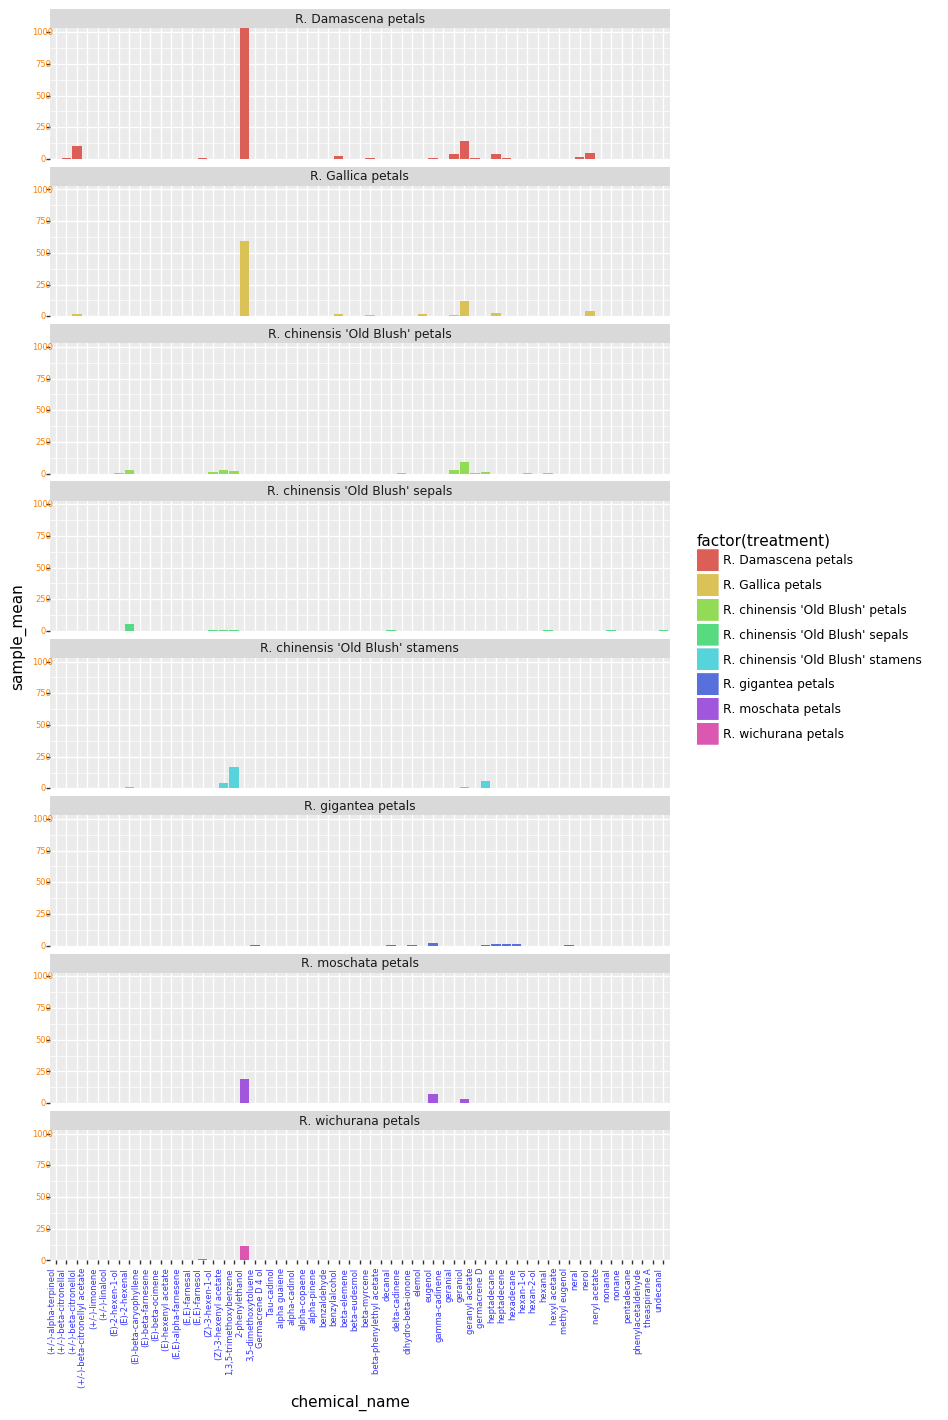

<ggplot: (315713060)>

In [13]:
# width = figure_size[0]
# height = figure_size[0] * aspect_ratio
gray = '#666666'
orange = '#FF8000'
blue = '#3333FF'

p1 = (ggplot(data)
 + aes('chemical_name','sample_mean',fill='factor(treatment)')
 + geom_col()
+ facet_wrap('~treatment', dir='v',ncol=1)
 + scale_y_continuous(expand = (0,0))
 + theme(axis_text_x=element_text(rotation=90, hjust=1, fontsize=6, color=blue))
 + theme(axis_text_y=element_text(rotation=0, hjust=2, fontsize=6, color=orange))
         + theme(figure_size = (8, 16))
)

p1 + theme(panel_background=element_rect(fill=blue)
       )

p1